### sma(이동 평균)

- 연속된 데이터의 평균을 구함, 시계열 데이터에서 노이즈를 줄이고 전반적인 추세 파악
- 적절한 윈도우(기간)을 설정하여 데이터를 순차적으로 평균내어 계산

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.7 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, precision_recall_curve, confusion_matrix,
                           classification_report, average_precision_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from itertools import cycle

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
data = pd.read_csv('/content/drive/MyDrive/merged_V2.csv')
df = data

In [5]:
# sma 적용
coordinate_columns = [col for col in df.columns if '_x' in col or '_y' in col]

#sma 계산
def apply_sma(df, window_size):
    return df.rolling(window=window_size, min_periods=1).mean()

window_size = 10

for col in coordinate_columns:
    df[f"{col}_SMA"] = apply_sma(df[col], window_size)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


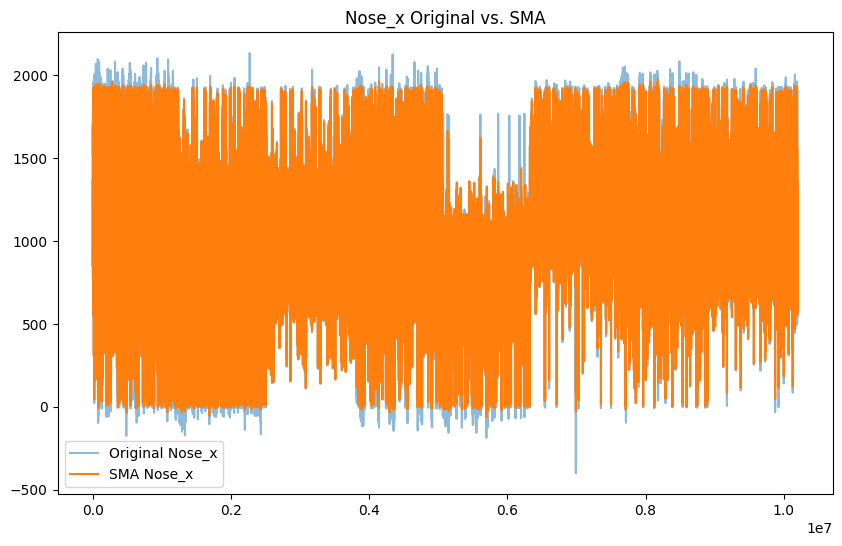

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(data['Nose_x'], label='Original Nose_x', alpha=0.5)
plt.plot(data['Nose_x_SMA'], label='SMA Nose_x')
plt.legend()
plt.title("Nose_x Original vs. SMA")
plt.show()

In [7]:
import numpy as np

def add_adversarial_noise_optimized(df, epsilon=2.0):
    # 필요한 컬럼 리스트
    sma_columns = [col for col in df.columns if col.endswith("_SMA") and ('_x' in col or '_y' in col)]
    # 원본 복사는 최소한으로 (필요한 부분만 복사)
    df_adv = df.copy(deep=False)  # 얕은 복사: 메모리 사용량이 줄어듦 (단, 내부 데이터가 수정되면 원본에도 영향이 있을 수 있음)

    # 모든 SMA 컬럼에 대해 한 번에 noise 행렬 생성 후 적용
    noise = np.random.uniform(-epsilon, epsilon, size=(df_adv.shape[0], len(sma_columns)))
    df_adv.loc[:, sma_columns] = df_adv.loc[:, sma_columns] + noise
    return df_adv

# 최적화된 함수 사용
df_adv = add_adversarial_noise_optimized(df, epsilon=2.0)


In [8]:
df = df.drop(['image_filename', 'Nose_x', 'Nose_y', 'LEye_x', 'LEye_y', 'REye_x', 'REye_y', 'LEar_x', 'LEar_y', 'REar_x', 'REar_y', 'LShoulder_x', 'LShoulder_y', 'RShoulder_x', 'RShoulder_y', 'LElbow_x', 'LElbow_y', 'RElbow_x', 'RElbow_y', 'LWrist_x', 'LWrist_y', 'RWrist_x', 'RWrist_y', 'LHip_x', 'LHip_y', 'RHip_x', 'RHip_y', 'LKnee_x', 'LKnee_y', 'RKnee_x', 'RKnee_y', 'LAnkle_x', 'LAnkle_y', 'RAnkle_x', 'RAnkle_y', 'Head_x', 'Head_y', 'Neck_x', 'Neck_y', 'Hip_x', 'Hip_y', 'LBigToe_x', 'LBigToe_y', 'RBigToe_x', 'RBigToe_y', 'LSmallToe_x', 'LSmallToe_y', 'RSmallToe_x', 'RSmallToe_y', 'LHeel_x', 'LHeel_y', 'RHeel_x', 'RHeel_y', 'gender', 'level','path'], axis=1)

In [9]:
encoder = LabelEncoder()
encoder.fit(data['label'])

df["label"] = encoder.transform(data['label'])
# 0 = jump, 1 = spin, 2 = step

In [10]:
X = df.drop(['label'] , axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6525518, 52)
(2039225, 52)
(6525518,)
(2039225,)
(1631380, 52)
(1631380,)


In [12]:
!sudo fallocate -l 16G /swapfile
!sudo chmod 600 /swapfile
!sudo mkswap /swapfile
!sudo swapon /swapfile
!free -h  # RAM & Swap 확인

Setting up swapspace version 1, size = 16 GiB (17179865088 bytes)
no label, UUID=3465af75-3858-443f-8b6f-fab1aab1286f
swapon: /swapfile: swapon failed: Invalid argument
               total        used        free      shared  buff/cache   available
Mem:            50Gi        23Gi       3.6Gi       1.0Mi        23Gi        26Gi
Swap:             0B          0B          0B


In [13]:
# 모델 정의
models = {
    # 'Extra Trees': ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    # 'CatBoost': CatBoostClassifier(iterations=50, random_state=42, verbose=0),
    # 'LightGBM': LGBMClassifier(n_estimators=50, random_state=42, n_jobs=-1),
     'XGBoost': XGBClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
}

In [14]:
kf = KFold(n_splits=5, shuffle=False)
cv_scores = []

In [15]:
import numpy as np
import gc

# 예측 확률 배열을 float32로 생성하여 메모리 사용 최적화
test_predictions = {
    name: np.zeros((X_test.shape[0], len(np.unique(Y_test))), dtype=np.float64)
    for name in models.keys()
}

# X_test도 numpy 배열로 변환 (한번만 변환)
X_test_np = X_test.values

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n=== Fold {fold+1} ===")

    # numpy 배열로 변환하여 메모리 사용 최적화
    X_train_fold = X_train.iloc[train_idx].values
    X_val_fold = X_train.iloc[val_idx].values
    Y_train_fold = Y_train.iloc[train_idx].values
    Y_val_fold = Y_train.iloc[val_idx].values

    for name, model in models.items():
        print(f"Training {name}...")

        model.fit(X_train_fold, Y_train_fold)

        # 훈련 세트 성능 평가
        Y_train_pred = model.predict(X_train_fold)
        print("\n--- Training Set Performance ---")
        print(classification_report(Y_train_fold, Y_train_pred))

        # 검증 세트 성능 평가
        Y_val_pred = model.predict(X_val_fold)
        print("\n--- Validation Set Performance ---")
        print(classification_report(Y_val_fold, Y_val_pred))

        # Test Set 예측값 저장 (Soft Voting을 위해 확률 예측값 사용)
        test_predictions[name] += model.predict_proba(X_test_np) / kf.n_splits

    # fold가 끝난 후 사용한 변수 삭제 및 가비지 컬렉션
    del X_train_fold, X_val_fold, Y_train_fold, Y_val_fold
    gc.collect()

# 최종 테스트 세트 평가 (앙상블 방식)
for name, pred_proba in test_predictions.items():
    print(f"\n=== Final Test Evaluation ({name}) - Averaged Over Folds ===")
    # 확률 예측값을 가장 높은 클래스 선택으로 변환
    Y_test_pred = np.argmax(pred_proba, axis=1)
    print("\n--- Test Set Performance ---")
    print(classification_report(Y_test, Y_test_pred))



=== Fold 1 ===
Training XGBoost...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       0.69      0.78      0.73   2357516
           1       0.62      0.62      0.62   1681554
           2       0.64      0.47      0.55   1181344

    accuracy                           0.66   5220414
   macro avg       0.65      0.62      0.63   5220414
weighted avg       0.65      0.66      0.65   5220414


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.69      0.77      0.73    590021
           1       0.61      0.62      0.62    420720
           2       0.64      0.47      0.54    294363

    accuracy                           0.66   1305104
   macro avg       0.65      0.62      0.63   1305104
weighted avg       0.65      0.66      0.65   1305104

Training Random Forest...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0     


=== Confusion Matrix (XGBoost) ===


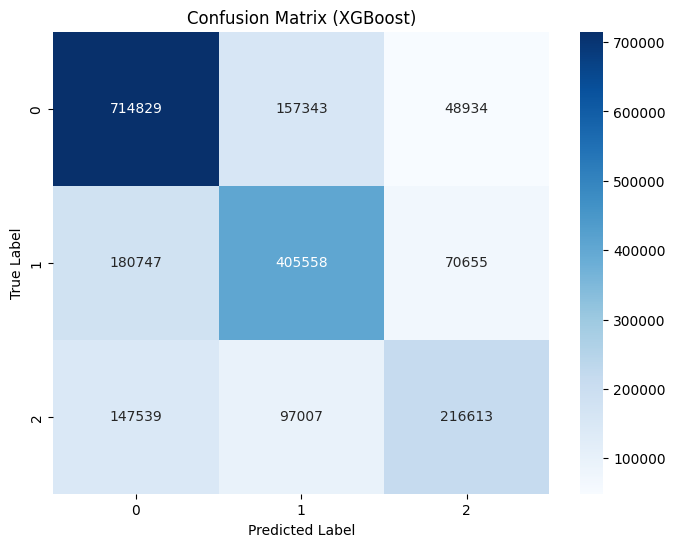


=== Confusion Matrix (Random Forest) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


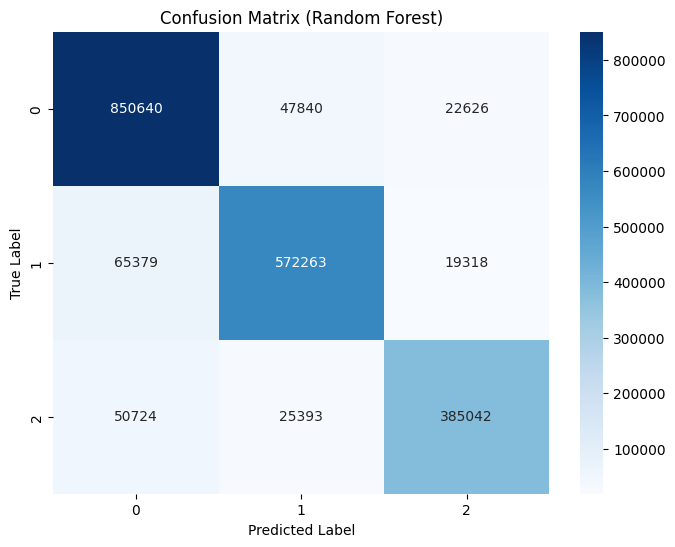

In [16]:
class_names = np.unique(Y_test)

for name, model in models.items():
    print(f"\n=== Confusion Matrix ({name}) ===")

    Y_test_pred = model.predict(X_test)

    cm = confusion_matrix(Y_test, Y_test_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix ({name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


=== Evaluating XGBoost ===
XGBoost Y_test_pred shape: (2039225,)
XGBoost Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-17-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


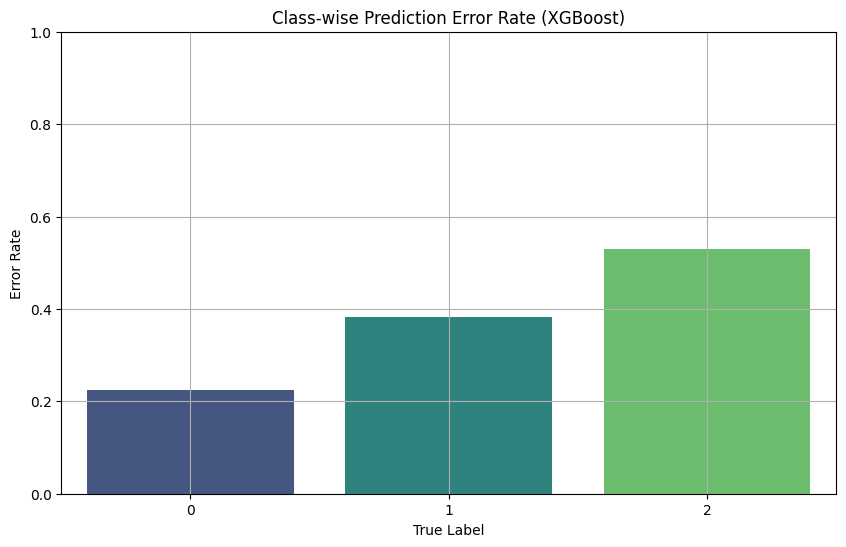

True Label
0    0.223945
1    0.382675
2    0.530286
Name: Error, dtype: float64

=== Evaluating Random Forest ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Random Forest Y_test_pred shape: (2039225,)
Random Forest Y_test_pred (first 5): [0 2 1 1 0]


<ipython-input-17-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


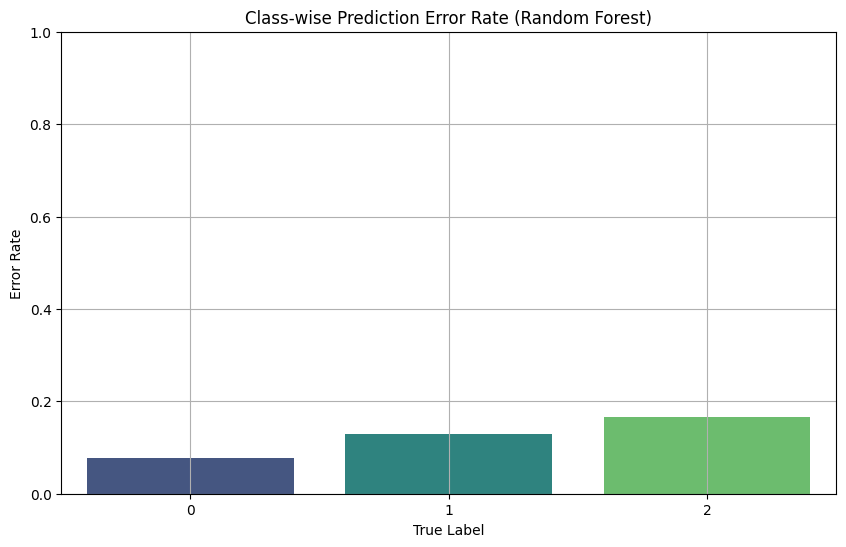

True Label
0    0.076502
1    0.128923
2    0.165056
Name: Error, dtype: float64


In [17]:
for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")

    # 예측값 생성
    Y_test_pred = model.predict(X_test)

    # 예측값 차원 확인
    print(f"{name} Y_test_pred shape: {Y_test_pred.shape}")

    # 1차원 변환 (필요할 경우)
    if Y_test_pred.ndim > 1:
        if Y_test_pred.shape[1] > 1:
            print(f"Warning: {name} predict() returned probabilities! Using argmax().")
            Y_test_pred = Y_test_pred.argmax(axis=1)
        else:
            Y_test_pred = Y_test_pred.ravel()

    print(f"{name} Y_test_pred (first 5): {Y_test_pred[:5]}")

    # 예측 오류 분석
    error = pd.DataFrame({
        "True Label": Y_test,
        "Predicted Label": Y_test_pred
    })

    error["Error"] = (error["True Label"] != error["Predicted Label"]).astype(int)
    classwise_error = error.groupby("True Label")["Error"].mean()

    # 클래스별 오류 비율 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")
    plt.title(f"Class-wise Prediction Error Rate ({name})")
    plt.xlabel("True Label")
    plt.ylabel("Error Rate")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    print(classwise_error)



=== ROC Curve Analysis (XGBoost) ===


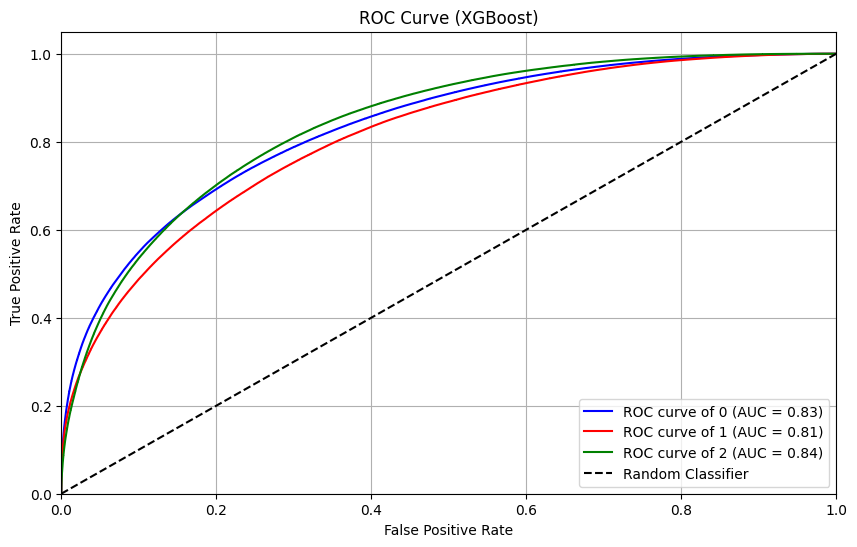


=== AUC Scores ===
0: 0.834
1: 0.811
2: 0.841

=== ROC Curve Analysis (Random Forest) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


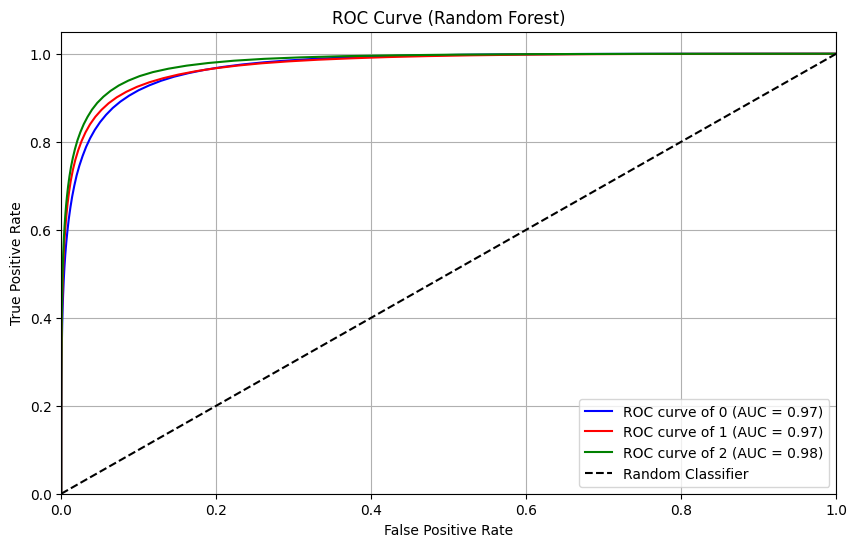


=== AUC Scores ===
0: 0.971
1: 0.973
2: 0.980


In [18]:
for name, model in models.items():
    print(f"\n=== ROC Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 FPR, TPR, AUC 저장
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_scores = {}

    # 클래스별 ROC 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        fpr[i], tpr[i], _ = roc_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 ROC 변환
            y_pred_proba[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores[class_name] = roc_auc[i]

    # ROC 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            label=f'ROC curve of {class_name} (AUC = {roc_auc[i]:.2f})'
        )

    # 완벽한 예측선을 추가
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # AUC 점수 출력
    print("\n=== AUC Scores ===")
    for class_name, score in auc_scores.items():
        print(f"{class_name}: {score:.3f}")




=== Precision-Recall Curve Analysis (XGBoost) ===


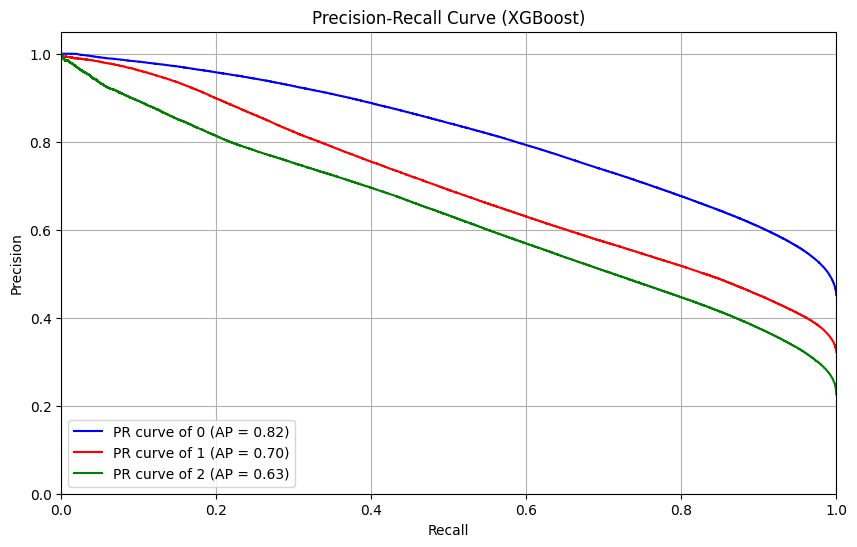


=== Average Precision Scores ===
0: 0.817
1: 0.698
2: 0.631

=== Precision-Recall Curve Analysis (Random Forest) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


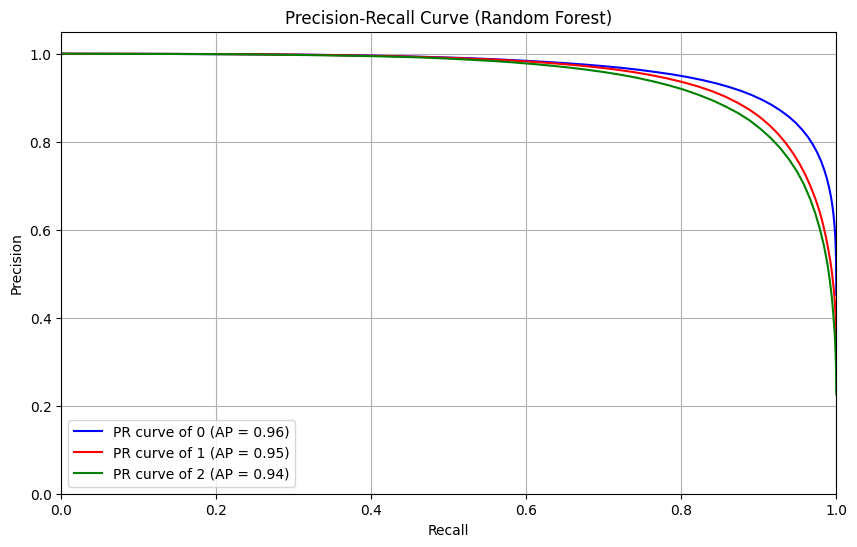


=== Average Precision Scores ===
0: 0.964
1: 0.951
2: 0.942


In [19]:
for name, model in models.items():
    print(f"\n=== Precision-Recall Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Precision, Recall, AP 저장
    precision = dict()
    recall = dict()
    avg_precision = dict()
    ap_scores = {}

    # 클래스별 PR 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        precision[i], recall[i], _ = precision_recall_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 PR 변환
            y_pred_proba[:, i]
        )
        avg_precision[i] = average_precision_score(
            (Y_test == class_name).astype(int),
            y_pred_proba[:, i]
        )
        ap_scores[class_name] = avg_precision[i]

    # PR 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            recall[i],
            precision[i],
            color=color,
            label=f'PR curve of {class_name} (AP = {avg_precision[i]:.2f})'
        )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # AP 점수 출력
    print("\n=== Average Precision Scores ===")
    for class_name, score in ap_scores.items():
        print(f"{class_name}: {score:.3f}")


=== Calibration Analysis (XGBoost) ===


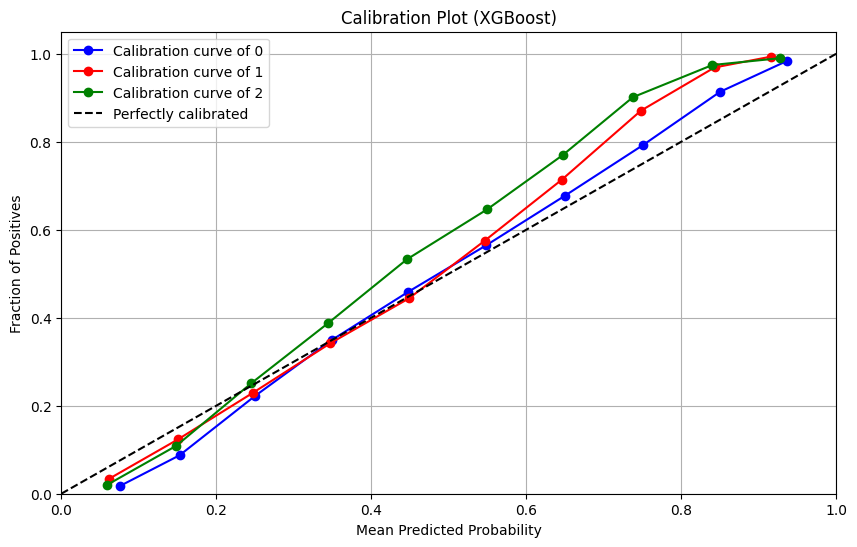


=== Calibration Scores ===
0: 0.036
1: 0.050
2: 0.079

=== Calibration Analysis (Random Forest) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


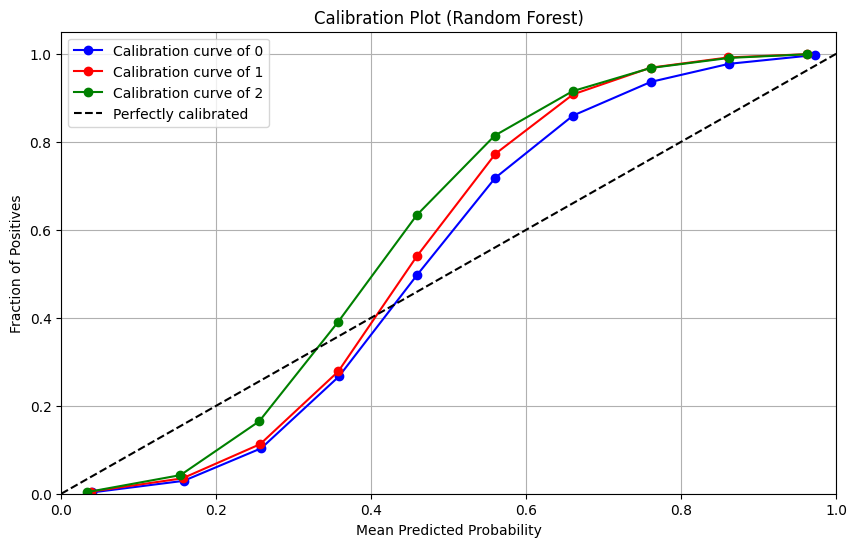


=== Calibration Scores ===
0: 0.112
1: 0.129
2: 0.132


In [20]:
for name, model in models.items():
    print(f"\n=== Calibration Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Calibration 정보 저장
    prob_true = dict()
    prob_pred = dict()
    calibration_scores = {}

    # 그래프 색상 설정
    colors = cycle(['blue', 'red', 'green'])

    # 캘리브레이션 곡선 계산
    plt.figure(figsize=(10, 6))
    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        prob_true[i], prob_pred[i] = calibration_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 변환
            y_pred_proba[:, i],
            n_bins=10
        )
        # 신뢰도 계산 (절대 오차의 평균)
        calibration_scores[class_name] = np.mean(np.abs(prob_true[i] - prob_pred[i]))

        # Calibration Curve 그리기
        plt.plot(
            prob_pred[i],
            prob_true[i],
            marker='o',
            color=color,
            label=f'Calibration curve of {class_name}'
        )

    # 완벽히 보정된 모델 기준선 추가
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot ({name})')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Calibration Score 출력
    print("\n=== Calibration Scores ===")
    for class_name, score in calibration_scores.items():
        print(f"{class_name}: {score:.3f}")


=== Macro‑average Curves (XGBoost) ===


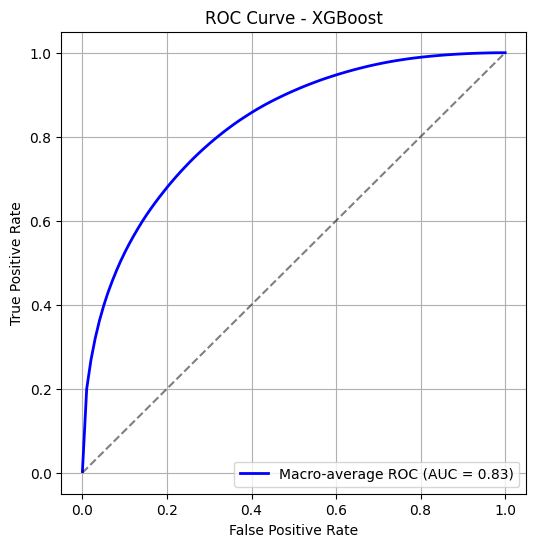

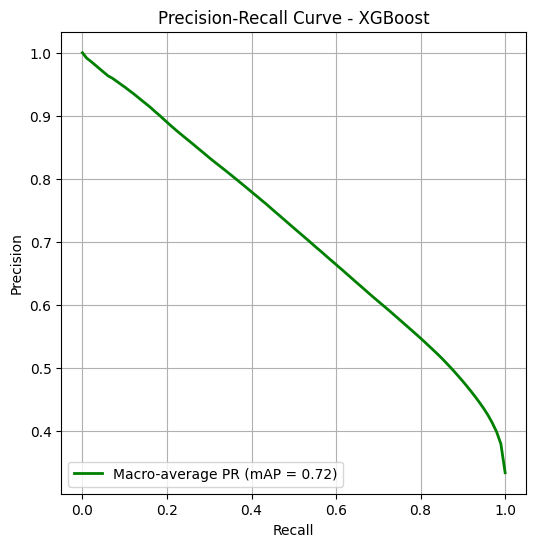

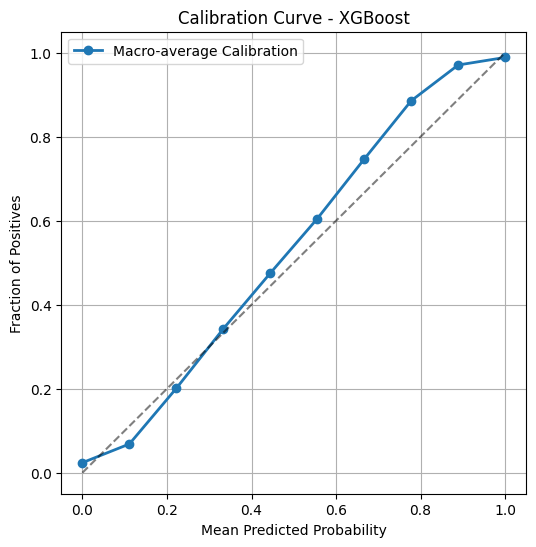


=== Macro‑average Curves (Random Forest) ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


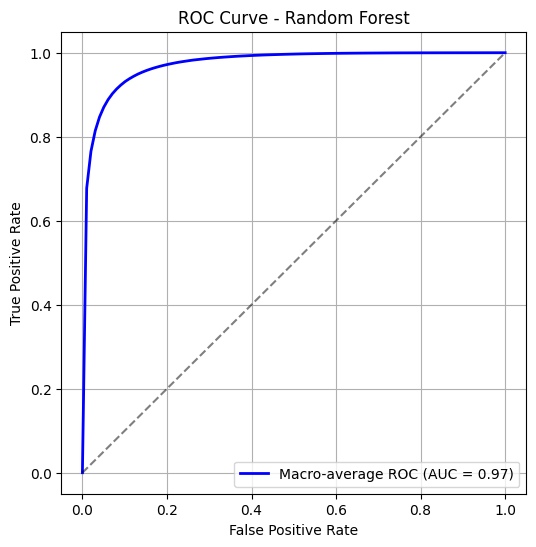

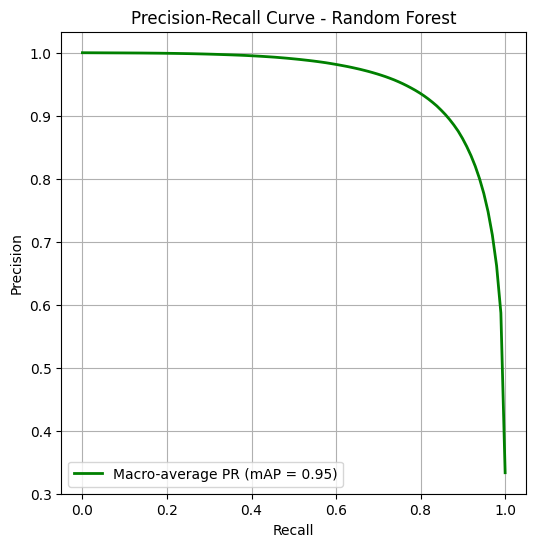

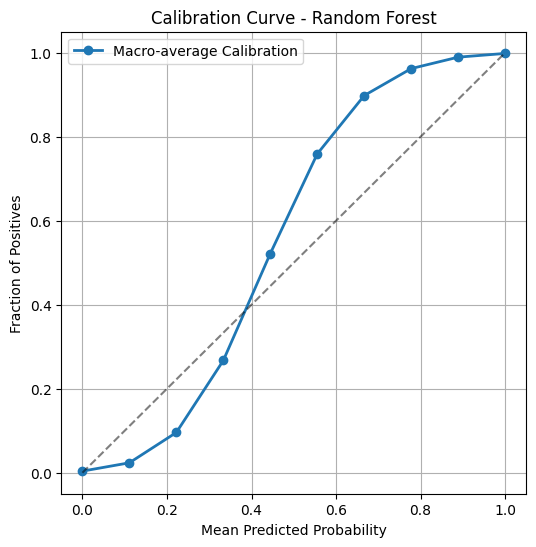

In [21]:

from sklearn.preprocessing import label_binarize

for name, model in models.items():
    print(f"\n=== Macro‑average Curves ({name}) ===")

    # 1) 테스트셋 예측 확률
    y_pred_proba = model.predict_proba(X_test)  # shape (n_samples, n_classes)

    # 2) 레이블 바이너리화
    classes = np.unique(Y)
    n_classes = len(classes)
    Y_test_bin = label_binarize(Y_test.values, classes=classes)

    # 3) 클래스별 지표 계산 및 accumulators 초기화
    # ROC
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    # PR
    all_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(all_recall)
    # Calibration
    n_bins = 10
    common_pred = np.linspace(0, 1, n_bins)
    mean_frac = np.zeros_like(common_pred)

    # 개별 클래스 지표 계산 후 보간해 누적
    for i in range(n_classes):
        # ROC
        fpr_i, tpr_i, _ = roc_curve(Y_test_bin[:, i], y_pred_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
        # PR
        prec_i, rec_i, _ = precision_recall_curve(Y_test_bin[:, i], y_pred_proba[:, i])
        # 정렬 후 보간
        idx = np.argsort(rec_i)
        mean_precision += np.interp(all_recall, rec_i[idx], prec_i[idx])
        # Calibration
        frac_i, pred_i = calibration_curve(Y_test_bin[:, i], y_pred_proba[:, i], n_bins=n_bins)
        mean_frac += np.interp(common_pred, pred_i, frac_i)

    # 평균 내기
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    mean_precision /= n_classes
    macro_map = np.mean([average_precision_score(Y_test_bin[:, i], y_pred_proba[:, i])
                         for i in range(n_classes)])
    mean_frac /= n_classes

    # ─── 시각화 ─────────────────────────────────────
    # Macro ROC
    plt.figure(figsize=(6, 6))
    plt.plot(all_fpr, mean_tpr, color="b", lw=2,
             label=f"Macro-average ROC (AUC = {macro_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Macro PR
    plt.figure(figsize=(6, 6))
    plt.plot(all_recall, mean_precision, color="g", lw=2,
             label=f"Macro-average PR (mAP = {macro_map:.2f})")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # Macro Calibration
    plt.figure(figsize=(6, 6))
    plt.plot(common_pred, mean_frac, marker='o', lw=2,
             label="Macro-average Calibration")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title(f"Calibration Curve - {name}")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()